# 1.시계열 데이터 준비

칼럼 종류:Date, Open, High, Low, Close, Adj Close, Volume 중 Close(종가)만 사용

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 삼성전자
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
1980-12-12    0.513393
1980-12-15    0.486607
1980-12-16    0.450893
1980-12-17    0.462054
1980-12-18    0.475446
Name: Close, dtype: float64

# 2.각종 전처리 수행

결측치 처리

In [18]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

로그 변환

In [19]:
# 로그 변환 시도 
ts_log = np.log(ts)

# 3.시계열 안정성 분석

In [20]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() #이동표준편차 시계열
    
    #원본시계열, 이동평균, 이동표준편차 plot 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [21]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메소드 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    #adfuller 메소드의 리턴값 정리, 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4],  index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

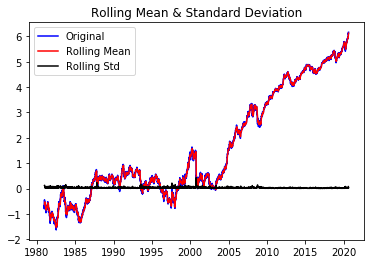

Results of Dickey-Fuller Test:
Test Statistic                    0.541664
p-value                           0.986086
#Lags Used                       14.000000
Number of Observations Used    9993.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [22]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 4.학습, 테스트 데이터셋 생성

학습, 테스트 데이터셋 분리

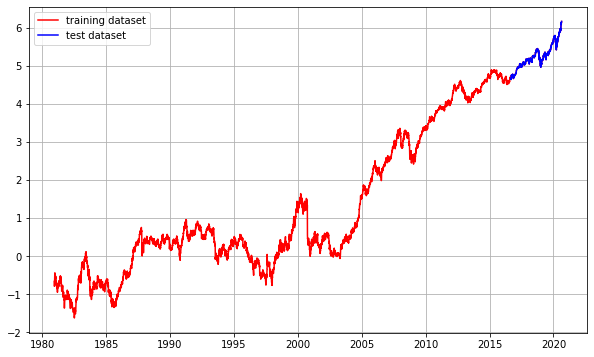

In [23]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5.적정 ARIMA 모수 찾기

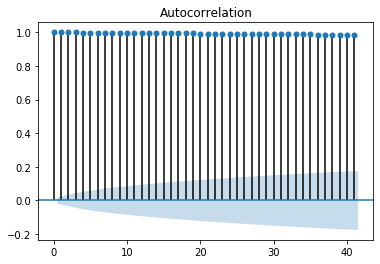

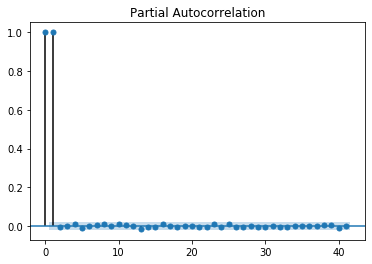

In [24]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -25.442452
p-value                           0.000000
#Lags Used                       13.000000
Number of Observations Used    9993.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -27.049673
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9967.000000
Critical Value (1%)              -3.431006
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64


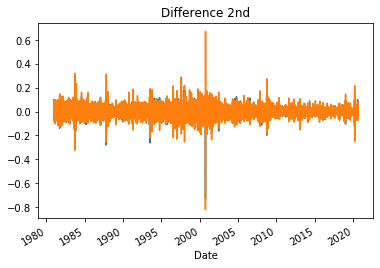

In [25]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6.ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련, 모델 테스트 및 플로팅, 최종 예측 모델 정확도 측정(MAPE)

In [26]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 9006
Model:                 ARIMA(1, 1, 0)   Log Likelihood               18786.852
Method:                       css-mle   S.D. of innovations              0.030
Date:                Fri, 21 Aug 2020   AIC                         -37567.703
Time:                        14:46:25   BIC                         -37546.386
Sample:                             1   HQIC                        -37560.450
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.826      0.068   -4.34e-05       0.001
ar.L1.D.Close     0.0242      0.011      2.295      0.022       0.004       0.045
                                    Root

/home/aiffel0034/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0034/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


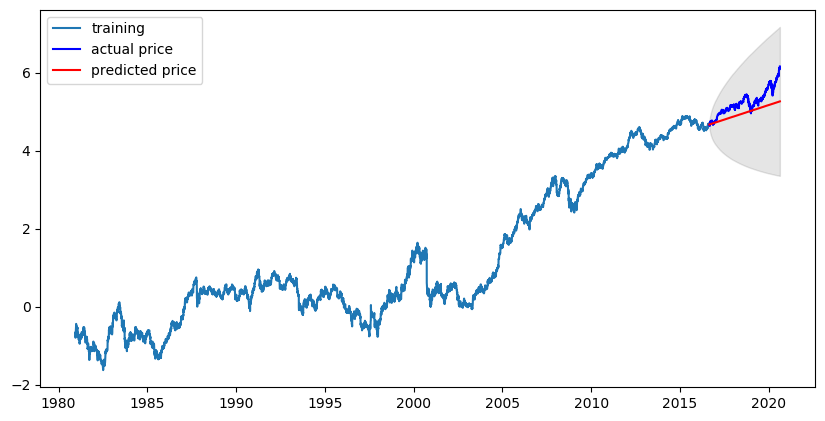

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5288.734567020774
MAE:  53.97298323360739
RMSE:  72.72368642348086
MAPE: 23.13%


## 후기

In [ ]:
너무 두서가 없어서 힘들었다. 주식을 좋아하지만 